# <a href="https://www.kaggle.com/c/competitive-data-science-predict-future-sales">Предсказание будущих продаж</a>

**Задача:***
``Вам предоставляются ежедневные исторические данные о продажах. Задача состоит в прогнозировании общего количества продуктов, проданных в каждом магазине для тестового набора.``

**Описание файлов**: 

- ``sales_train.csv`` - обучающий набор. Ежедневные исторические данные с января 2013 года по октябрь 2015 года.
- ``test.csv`` -  тестовый набор. Вам необходимо спрогнозировать продажи этих магазинов и продуктов на ноябрь 2015 года.
- ``sample_submission.csv`` - файл с примерами представления в правильном формате.
- ``items.csv``  - дополнительная информация о товарах / товарах.
- ``item_categories.csv``  - дополнительная информация о категориях товаров.
- ``shops.csv``- дополнительная информация о магазинах.

**Поля данных**: 

- ``ID``- идентификатор, который представляет кортеж (магазин, товар) в тестовом наборе
- ``shop_id`` - уникальный идентификатор магазина
- ``item_id`` - уникальный идентификатор товара
- ``item_category_id``  - уникальный идентификатор категории товара
- ``item_cnt_day`` - количество проданных товаров. Вы прогнозируете ежемесячную сумму этой меры
- ``item_price``  - текущая цена товара
- ``data`` - дата в формате дд / мм / гггг
- ``date_block_num`` - порядковый номер месяца, используемый для удобства. В январе 2013 года - 0, в феврале 2013 года - 1, ..., в октябре 2015 года - 33
- ``item_name`` - название предмета
- ``shop_name``  - название магазина
- ``item_category_name`` - название категории товара

Подключим все необходимые библиотеки для обработки данных

In [1]:
import gc # сборщик мусора для удаления ненужных данных в оперативной памяти
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Проверка данных

Загружаем наши данные, просмотрим их и проверяем на наличие пустых значений

In [2]:
train = pd.read_csv(r'./data/sales_train.csv')
test = pd.read_csv(r'./data/test.csv')
sample_sub = pd.read_csv(r'./data/sample_submission.csv')
items = pd.read_csv(r'./data/items.csv')
items_cat = pd.read_csv(r'./data/item_categories.csv')
shops = pd.read_csv(r'./data/shops.csv')

In [3]:
items_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [4]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
sample_sub.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [7]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [8]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [9]:
items_cat.isnull().sum()

item_category_name    0
item_category_id      0
dtype: int64

In [10]:
items.isnull().sum()

item_name           0
item_id             0
item_category_id    0
dtype: int64

In [11]:
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [12]:
shops.isnull().sum()

shop_name    0
shop_id      0
dtype: int64

In [13]:
test.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

# Преобразование данных

Приведем наши данные к необходимому формату, объединим таблицы. Удалим из train выборки то чего нет в test выборке. Добавим новые признаки. Приведем целевую переменную item_cnt_day к формату 0, 20.

In [14]:
test_shops = test.shop_id.unique() # в train выборке у нас есть магазины и товары которых нет в test выборке
train = train[train.shop_id.isin(test_shops)] # поэтому мы их удалим
test_items = test.item_id.unique()
train = train[train.item_id.isin(test_items)]
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [15]:
def split_city(str):
  return str.split(sep=" ", maxsplit=1)[0]

def split_shop(str):
  return str.split(sep=" ", maxsplit=1)[1]

def split_item_cat1(str):
  return str.split(sep="-", maxsplit=1)[0]

def split_item_cat2(str):
  splitted = str.split(sep="-", maxsplit=1)
  if len(splitted) == 1:
    return "No info"
  else:
    return splitted[1]

def prepare_data(data): # функция для объединения таблиц и создания новых признаков из старых
  full_items = items.merge(items_cat, left_on="item_category_id", right_on="item_category_id")
  full_data = data.merge(shops, left_on="shop_id", right_on="shop_id").merge(full_items, left_on="item_id", right_on="item_id")
  del full_items
  full_data['city'] = full_data['shop_name'].apply(split_city)
  full_data['new_shop_name'] = full_data['shop_name'].apply(split_shop)
  full_data['item_cat1'] = full_data['item_category_name'].apply(split_item_cat1)
  full_data['item_cat2'] = full_data['item_category_name'].apply(split_item_cat2)
  full_data.drop(['shop_id', 'item_id', 'shop_name', 'item_name', 'item_category_id', 'item_category_name'], axis=1, inplace=True)
  return full_data

In [16]:
%%time
new_train = prepare_data(train.copy())
new_test = prepare_data(test.copy())

Wall time: 11.5 s


In [17]:
new_train = new_train[new_train.item_price<100000]
new_train = new_train[new_train.item_cnt_day<1001]
###

new_test['date_block_num'] = 34 # добавляем порядковый номер месяца в test
new_test.drop(['ID'], axis=1, inplace=True)
new_train.drop(['date'], axis=1, inplace=True)
new_train['item_cnt_day'] = new_train['item_cnt_day'].clip(0, 20) # преобразуем значения item_cnt_day в необходимый формат > 0
new_train['month'] = new_train['date_block_num'] % 12 # добавляем номер месяца в train
new_test['month'] = new_test['date_block_num'] % 12 # добавляем номер месяца в test
new_train.drop(['item_price'], axis=1, inplace=True)

In [18]:
gc.collect()

15

In [19]:
new_train

,date_block_num,item_cnt_day,city,new_shop_name,item_cat1,item_cat2,month
0,0,1.0,Ярославль,"ТЦ ""Альтаир""",Кино,Blu-Ray,0
1,0,1.0,Москва,"ТРК ""Атриум""",Кино,Blu-Ray,0
2,0,1.0,Москва,"ТРК ""Атриум""",Кино,Blu-Ray,0
3,0,1.0,Москва,"ТРК ""Атриум""",Кино,Blu-Ray,0
4,0,1.0,Москва,"ТРК ""Атриум""",Кино,Blu-Ray,0
...,...,...,...,...,...,...,...
1224434,33,1.0,Цифровой,склад 1С-Онлайн,Программы,Для дома и офиса (Цифра),9
1224435,33,1.0,Цифровой,склад 1С-Онлайн,Программы,Для дома и офиса (Цифра),9
1224436,33,3.0,Цифровой,склад 1С-Онлайн,Игры PC,Цифра,9
1224437,33,1.0,Цифровой,склад 1С-Онлайн,Игры PC,Цифра,9


In [20]:
new_test

,city,new_shop_name,item_cat1,item_cat2,date_block_num,month
0,Вологда,"ТРЦ ""Мармелад""",Игры,PS3,34,10
1,Волжский,"ТЦ ""Волга Молл""",Игры,PS3,34,10
2,Воронеж,"(Плехановская, 13)",Игры,PS3,34,10
3,Балашиха,"ТРК ""Октябрь-Киномир""",Игры,PS3,34,10
4,Адыгея,"ТЦ ""Мега""",Игры,PS3,34,10
...,...,...,...,...,...,...
214195,Сергиев,"Посад ТЦ ""7Я""",Кино,Blu-Ray,34,10
214196,РостовНаДону,"ТЦ ""Мега""",Кино,Blu-Ray,34,10
214197,Самара,"ТЦ ""Мелодия""",Кино,Blu-Ray,34,10
214198,РостовНаДону,"ТРК ""Мегацентр Горизонт""",Кино,Blu-Ray,34,10


# Получение информации о данных

In [21]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1224438 entries, 0 to 1224438
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date_block_num  1224438 non-null  int64  
 1   item_cnt_day    1224438 non-null  float64
 2   city            1224438 non-null  object 
 3   new_shop_name   1224438 non-null  object 
 4   item_cat1       1224438 non-null  object 
 5   item_cat2       1224438 non-null  object 
 6   month           1224438 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 74.7+ MB


In [22]:
new_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   city            214200 non-null  object
 1   new_shop_name   214200 non-null  object
 2   item_cat1       214200 non-null  object
 3   item_cat2       214200 non-null  object
 4   date_block_num  214200 non-null  int64 
 5   month           214200 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 11.4+ MB


In [23]:
new_train.describe()

,date_block_num,item_cnt_day,month
count,1.224438e+06,1.224438e+06,1.224438e+06
mean,1.935471e+01,1.287572e+00,5.628643e+00
std,9.110718e+00,1.360732e+00,3.470049e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.200000e+01,1.000000e+00,3.000000e+00
50%,2.100000e+01,1.000000e+00,6.000000e+00
75%,2.700000e+01,1.000000e+00,9.000000e+00
max,3.300000e+01,2.000000e+01,1.100000e+01


# Визуализация

Посмотрим количество заказов по городам.

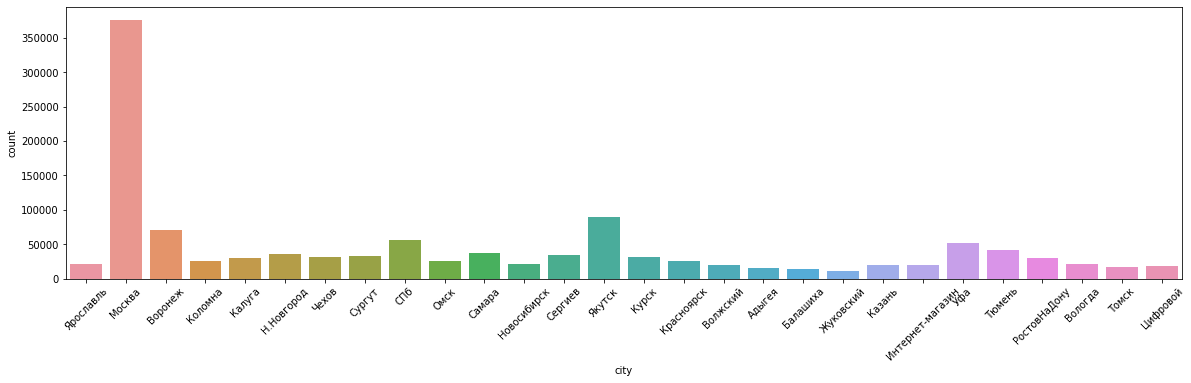

In [24]:
plt.figure(figsize=(20, 5))
city = sns.countplot(x='city', data=new_train)
city.set_xticklabels(city.get_xticklabels(), rotation=45);

Распределение покупок по магазинам.

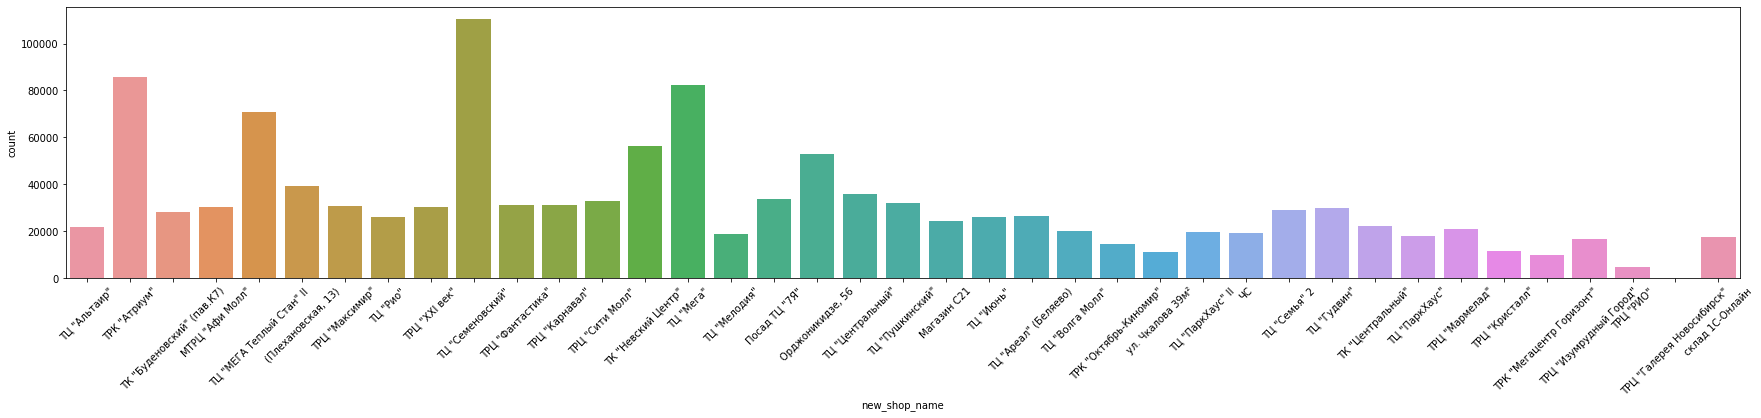

In [25]:
plt.figure(figsize=(30, 5))
shop_viz = sns.countplot(x='new_shop_name', data=new_train)
shop_viz.set_xticklabels(shop_viz.get_xticklabels(), rotation=45);

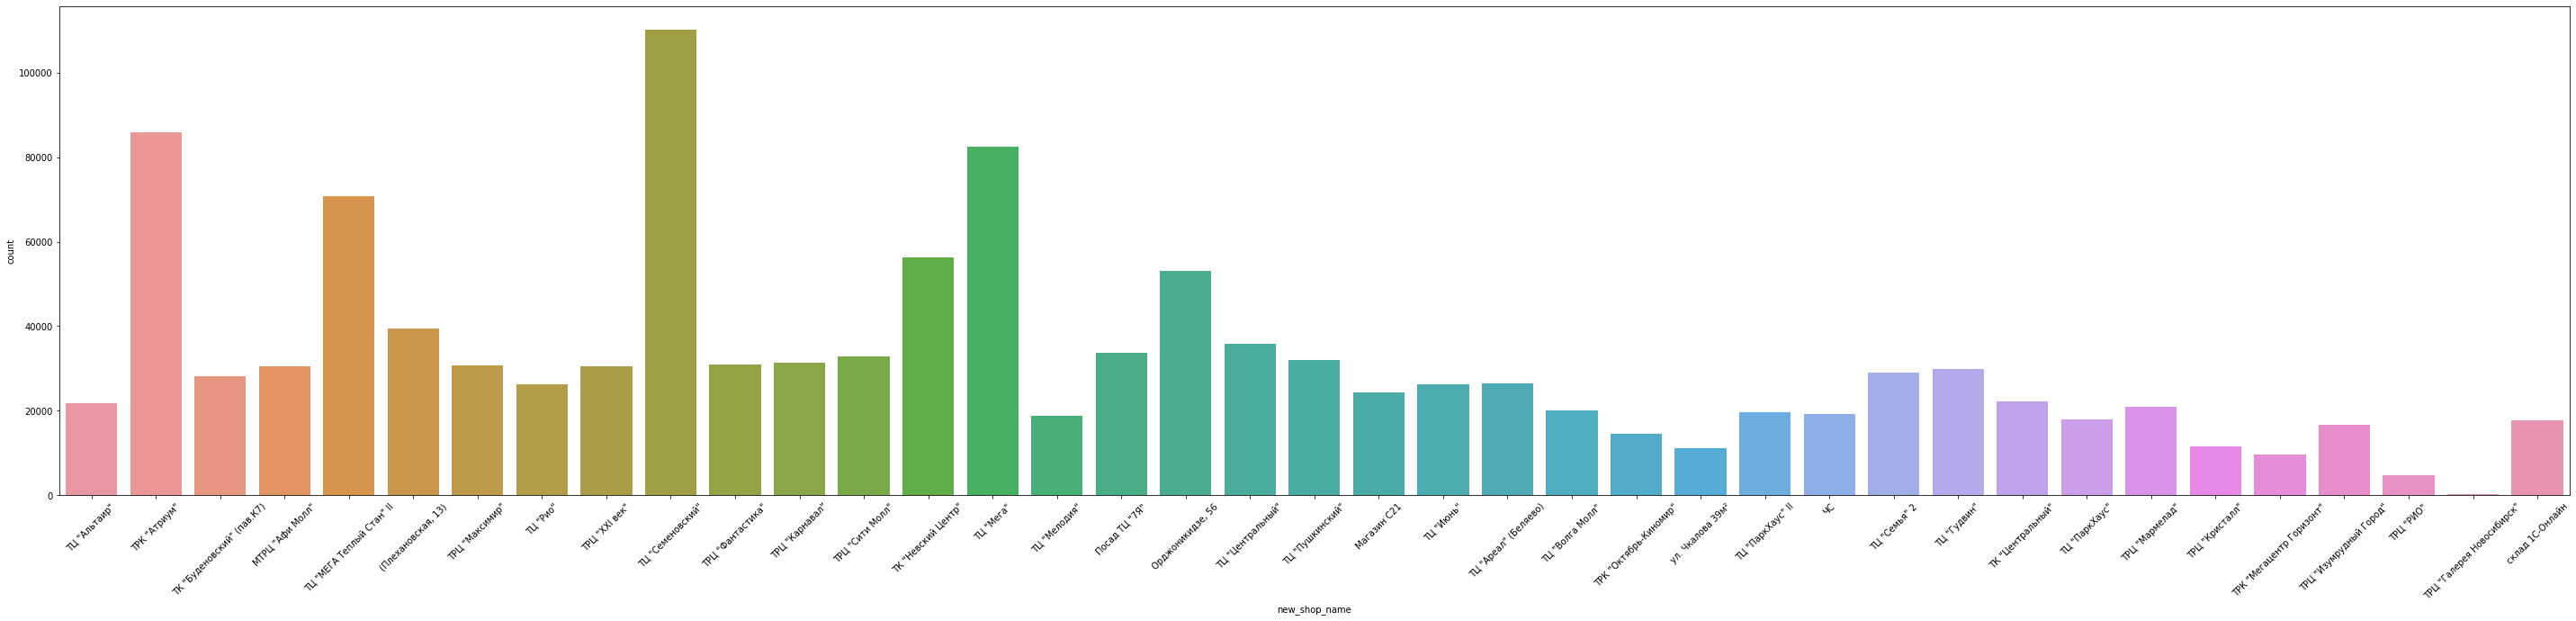

In [26]:
plt.figure(figsize=(50, 10))
shop_viz = sns.countplot(x='new_shop_name', data=new_train)
shop_viz.set_xticklabels(shop_viz.get_xticklabels(), rotation=45);

Распределение покупок по глобальным категориям.

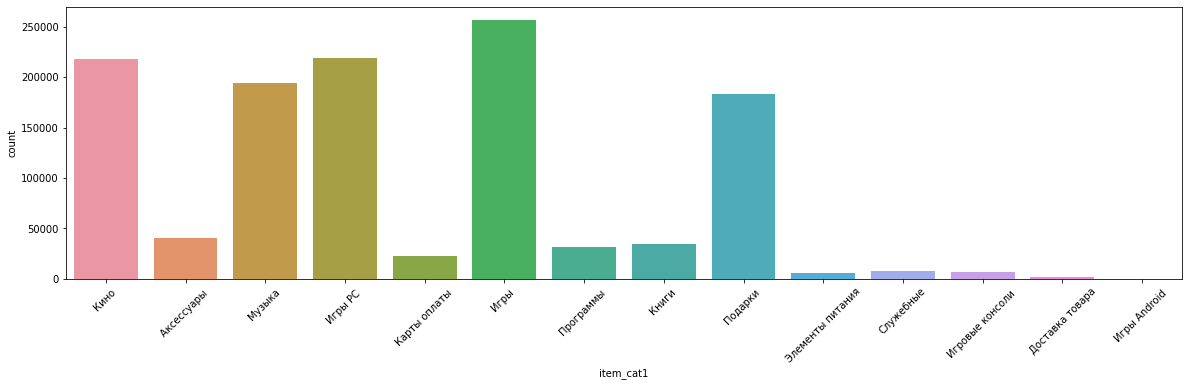

In [27]:
plt.figure(figsize=(20, 5))
item_name = sns.countplot(x='item_cat1', data=new_train)
item_name.set_xticklabels(item_name.get_xticklabels(), rotation=45);

Распределение покупок по локальным категориям.


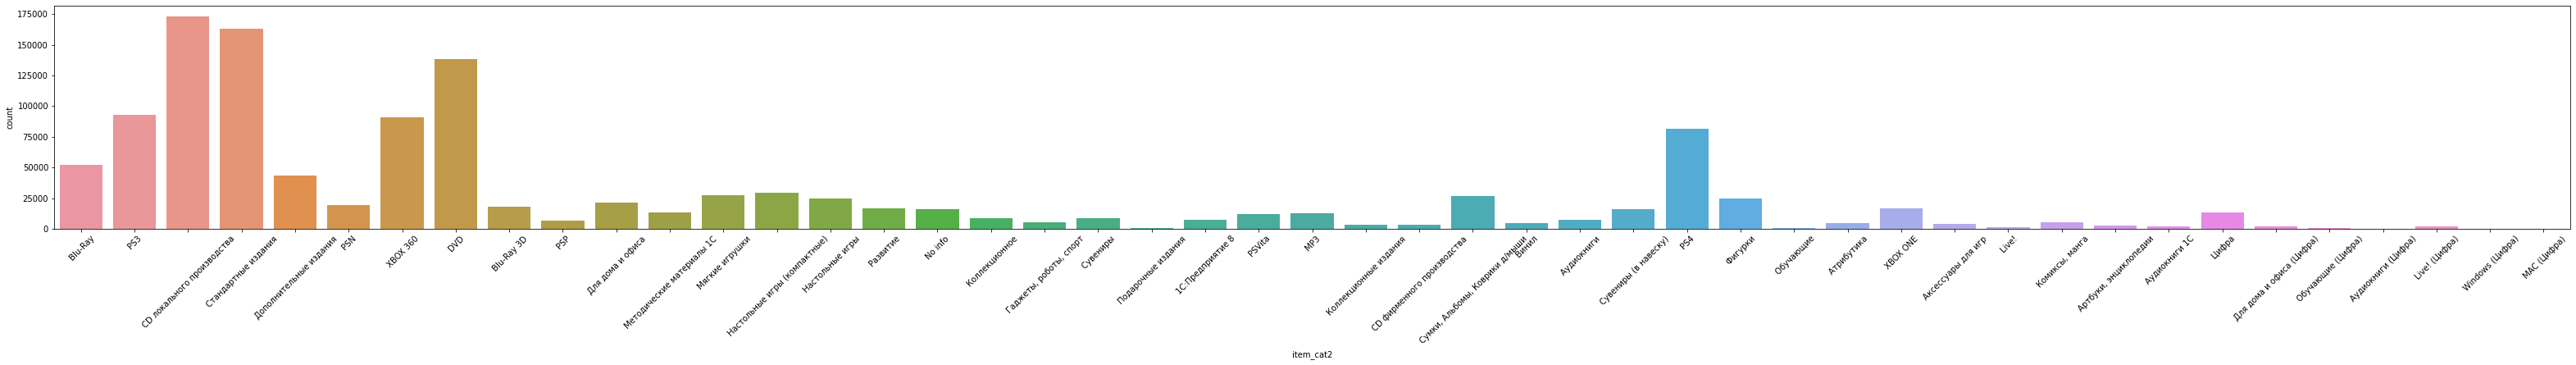

In [28]:
plt.figure(figsize=(55, 5))
item_label = sns.countplot(x='item_cat2', data=new_train)
item_label.set_xticklabels(item_label.get_xticklabels(), rotation=45);

Распределение покупок по месяцам.

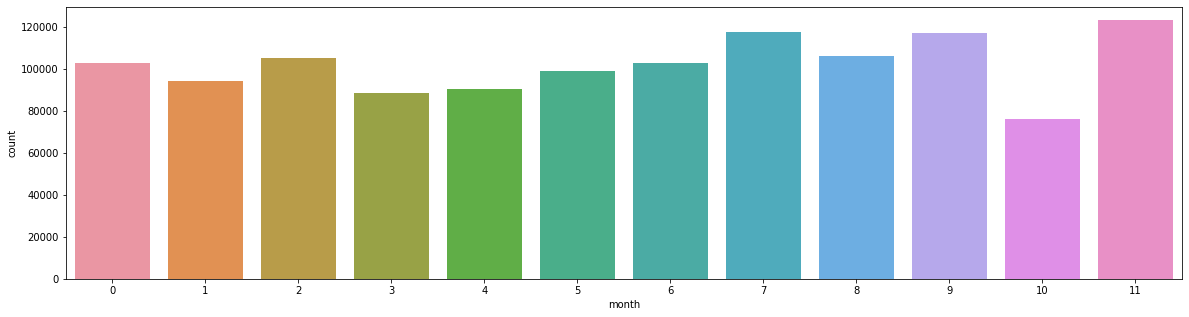

In [29]:
plt.figure(figsize=(20, 5))
sns.countplot(x='month', data=new_train);

<AxesSubplot:xlabel='item_cnt_day'>

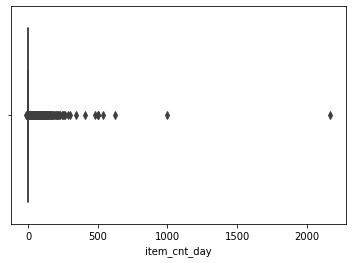

In [30]:
sns.boxplot(x=train.item_cnt_day)

<AxesSubplot:xlabel='item_price'>

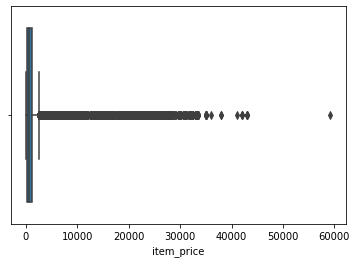

In [31]:
sns.boxplot(x=train.item_price)

# Подготавливаем данные для обучения моделей

In [32]:
X_train = new_train.drop(['item_cnt_day'], axis=1) # разделение на X и Y
Y_train = new_train['item_cnt_day']
X_test = new_test

In [33]:
cat_features = ['city', 'new_shop_name', 'item_cat1', 'item_cat2']

def into_numbers(data): # приводим к необходимому формату категориальные признаки
  num_data = pd.concat([data, pd.get_dummies(data['city'])], axis=1)
  num_data = pd.concat([num_data, pd.get_dummies(data['item_cat1'])], axis=1)
  num_data = pd.concat([num_data, pd.get_dummies(data['item_cat2'])], axis=1)
  num_data = pd.concat([num_data, pd.get_dummies(data['new_shop_name'])], axis=1)
  num_data.drop(cat_features, axis=1, inplace=True)
  return num_data

In [34]:
%%time
X_train_num = into_numbers(X_train.copy())
X_test_num = into_numbers(X_test.copy())

Wall time: 6.58 s


В train выборке отсутствуют 3 категории товаров, которые есть в test выборке, поэтому мы добавим их вручную в train выборке.

In [35]:
X_train_num[' Гарнитуры/Наушники'] = 0
X_train_num['PC ' ] = 0
X_train_num['Игры MAC '] = 0

In [36]:
X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1224438 entries, 0 to 1224438
Columns: 133 entries, date_block_num to Игры MAC 
dtypes: int64(5), uint8(128)
memory usage: 205.5 MB


Для XGBoost столбцы признаков должны быть в одном порядке и у train, и test выборок, поэтому мы отсортируем столбцы, чтобы получить одинаковый порядок столбцов.

In [37]:
X_train_num = X_train_num.reindex(sorted(X_train_num.columns), axis=1)
X_test_num = X_test_num.reindex(sorted(X_test_num.columns), axis=1)

Из-за того, что LightGBM не принимает не ascii-символы придется делать транслитерацию названий колонок.

In [38]:
def transliterate(name):
   # Словарь с заменами
   dictionary = {'а':'a','б':'b','в':'v','г':'g','д':'d','е':'e','ё':'e',
      'ж':'zh','з':'z','и':'i','й':'i','к':'k','л':'l','м':'m','н':'n',
      'о':'o','п':'p','р':'r','с':'s','т':'t','у':'u','ф':'f','х':'h',
      'ц':'c','ч':'cz','ш':'sh','щ':'scz','ъ':'','ы':'y','ь':'','э':'e',
      'ю':'u','я':'ja', 'А':'A','Б':'B','В':'V','Г':'G','Д':'D','Е':'E','Ё':'E',
      'Ж':'ZH','З':'Z','И':'I','Й':'I','К':'K','Л':'L','М':'M','Н':'N',
      'О':'O','П':'P','Р':'R','С':'S','Т':'T','У':'U','Ф':'F','Х':'H',
      'Ц':'C','Ч':'CZ','Ш':'SH','Щ':'SCH','Ъ':'','Ы':'y','Ь':'','Э':'E',
      'Ю':'U','Я':'YA',',':'','?':'',' ':'_','~':'','!':'','@':'','#':'',
      '$':'','%':'','^':'','&':'','*':'','(':'',')':'','-':'','=':'','+':'',
      ':':'',';':'','<':'','>':'','\'':'','"':'','\\':'','/':'','№':'',
      '[':'',']':'','{':'','}':'','ґ':'','ї':'', 'є':'','Ґ':'g','Ї':'i',
      'Є':'e', '—':''}
        
   # Циклически заменяем все буквы в строке
   for key in dictionary:
      name = name.replace(key, dictionary[key])
   return name

In [39]:
eng_cols = {}
for i in X_train_num.columns:
    eng_cols[str(i)] = transliterate(i)

In [40]:
X_train_num.rename(columns=eng_cols, inplace=True)
X_test_num.rename(columns=eng_cols, inplace=True)

In [41]:
gc.collect()

45

# Создание моделей

In [42]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Разбиваем данные train выборки на выборку для обучения и отложенную выборку для проверки качества моделей.

In [43]:
#X_test = train_cleaned_df.drop(labels=[0],axis=1)
X_train_check, X_test_check, y_train_check, y_test_check = train_test_split(X_train_num, Y_train, test_size=0.33, random_state=42) # нормализованные данные с использованием метода обработки категориальных признаков - get_dummies

# XGBoost

XGBoost - это алгоритм, который в последнее время доминирует в прикладном машинном обучении и соревнованиях Kaggle для структурированных или табличных данных.

XGBoost - это реализация деревьев решений с градиентным усилением, разработанных для скорости и производительности.


In [44]:
#%%time
#model_xgboost = xgboost.XGBRegressor()
#model_xgboost.fit(X_train_check, y_train_check)

In [45]:
#pred_xgb = model_xgboost.predict(X_test_check)
#xgboost_rmse = np.sqrt(mean_squared_error(y_test_check, pred_xgb))
#model_error['XGBoost'] = xgboost_rmse
#print(xgboost_rmse)

In [46]:
#xgboost.plot_importance(model_xgboost) # график важности признаков

In [54]:
param = {'max_depth':10,
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3,
         'seed':1,
         'eval_metric':'rmse'}

In [55]:
progress = dict()
xgbtrain = xgb.DMatrix(X_train_check, y_train_check)
watchlist  = [(xgbtrain,'train-rmse')]

In [56]:
bst = xgb.train(param, xgbtrain)
preds = bst.predict(xgb.DMatrix(X_test_check))

In [57]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test_check, preds))
print(rmse)

1.0347998778738925


# LightGBM

**LightGBM** - это платформа для повышения градиента, использующая алгоритмы обучения на основе дерева. Он предназначен для распространения и эффективности со следующими преимуществами:

- Более быстрая скорость обучения и высокая эффективность.
- Более низкое использование памяти.
- Лучшая точность.
- Поддержка параллельного и GPU обучения.
- Способен обрабатывать крупномасштабные данные.

In [51]:
import lightgbm as lgb

In [52]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 2 ** 7 - 1,
    'learning_rate': 0.005,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1
    }
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000,
                      valid_sets=[lgtrain, lgval],
                      early_stopping_rounds=100,
                      verbose_eval=50,
                      evals_result=evals_result)

    pred_test_y = np.expm1(model.predict(test_X, num_iteration=model.best_iteration))
    return pred_test_y, model, evals_result

In [53]:
pred_test, model, evals_result = run_lgb(X_train_check, y_train_check, X_test_check, y_test_check, X_test_num)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 820373, number of used features: 127
[LightGBM] [Info] Start training from score 1.288346
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 1.26667	valid_1's rmse: 1.2536
[100]	training's rmse: 1.20472	valid_1's rmse: 1.19178
[150]	training's rmse: 1.15801	valid_1's rmse: 1.14523
[200]	training's rmse: 1.12287	valid_1's rmse: 1.1104
[250]	training's rmse: 1.09922	valid_1's rmse: 1.08701
[300]	training's rmse: 1.08062	valid_1's rmse: 1.06887
[350]	training's rmse: 1.06897	valid_1's rmse: 1.05761
[400]	training's rmse: 1.06025	valid_1's rmse: 1.0494
[450]	training's rmse: 1.0539	valid_1's rmse: 1.0436
[500]	training's rmse: 1.04976	valid_1'